In [6]:
from glob import glob
import sys
sys.path.append('../')
import mvcomp as mvc
import nibabel as nb
import numpy as np
from matplotlib import pyplot as plt


# Generate false data
- pull data for three contrasts from one individual from nitrc
    - https://www.nitrc.org/frs/?group_id=1205#
- use this individual's three metrics as a toy example, modifying each metric by noise

```text
 sub001_sess1_INV2.nii.gz
22.95 MB	660	Any	.gz	10.1038/sdata.2014.54
 	
 sub001_sess1_T1map.nii.gz
40.05 MB	684	Any	.gz	10.1038/sdata.2014.54
 	
 sub001_sess1_T1w.nii.gz
43.06 MB	677	Any	.gz	10.1038/sdata.2014.54

...
```

In [3]:
# simulate data by simply multiplying the one subject by noise
# here we make the final subject MUCH more different (by scaling the noise by 10) to
# ensure that we can distinguish them properly by their D2

ID='sub001'
s1 = glob('./sub001*')
idx=2
for rep in range(3):
    idx2 = rep+idx
    for s in s1:
        new_ID = ID.replace("1",str(idx2))
        img = nb.load(s)
        d=img.get_fdata()
        print(img.shape)
        d[np.isnan(d)]=0
        d[np.isinf(d)]=0
        if rep == 2:
            print(f"new_ID: {new_ID} should be an outlier")
            scale=10 #create an outlier
        else:
            scale=1 
        d=d*scale*np.random.random(d.shape) #scale up the data
        out_fname = s.replace(ID,new_ID)
        print(out_fname)
        out_img = nb.Nifti1Image(d,affine=img.affine,header=img.header)
        out_img.update_header()
        out_img.to_filename(out_fname)


(240, 320, 320)
./sub002_sess1_INV2.nii.gz
(240, 320, 320)
./sub002_sess1_T1w.nii.gz
(240, 320, 320)
./sub002_sess1_T1map.nii.gz
(240, 320, 320)
./sub003_sess1_INV2.nii.gz
(240, 320, 320)
./sub003_sess1_T1w.nii.gz
(240, 320, 320)
./sub003_sess1_T1map.nii.gz
(240, 320, 320)
new_ID: sub004 should be an outlier
./sub004_sess1_INV2.nii.gz
(240, 320, 320)
new_ID: sub004 should be an outlier
./sub004_sess1_T1w.nii.gz
(240, 320, 320)
new_ID: sub004 should be an outlier
./sub004_sess1_T1map.nii.gz


In [4]:
s1 = glob('./sub001*')
s2 = glob('./sub002*')
s3 = glob('./sub003*')
s4 = glob('./sub004*')
all_Ss = [s1,s2,s3,s4]
print(all_Ss)

img = nb.load(s1[0])
_mask_d = (img.get_fdata()>100).astype(int)
mask_img = nb.Nifti1Image(_mask_d,affine=img.affine,header=img.header)
res = mvc.model_comp_simplified(all_Ss,mask=mask_img,verbosity=2)

[['./sub001_sess1_INV2.nii.gz', './sub001_sess1_T1w.nii.gz', './sub001_sess1_T1map.nii.gz'], ['./sub002_sess1_T1map.nii.gz', './sub002_sess1_T1w.nii.gz', './sub002_sess1_INV2.nii.gz'], ['./sub003_sess1_INV2.nii.gz', './sub003_sess1_T1map.nii.gz', './sub003_sess1_T1w.nii.gz'], ['./sub004_sess1_INV2.nii.gz', './sub004_sess1_T1map.nii.gz', './sub004_sess1_T1w.nii.gz']]
No 'model_feature_image_list' was provided
	- Model features will be iteratively computed as the mean of all other subjects (leave one out)
subject None feature matrix creation in 5.66 s
subject None feature matrix creation in 5.9 s
subject None feature matrix creation in 5.9 s
subject None feature matrix creation in 6.03 s
Total time for mahalanobis distance calculation on 4 subjects with 4702024 voxels: 7.03s


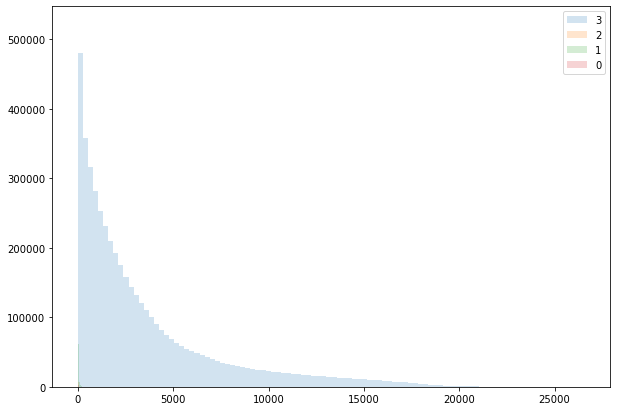

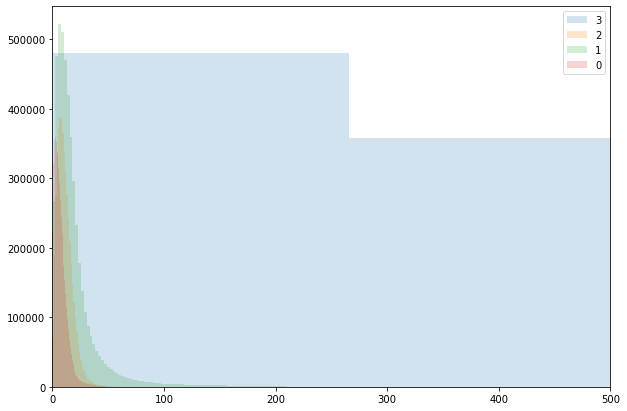

In [15]:
plt.figure(figsize=(10,7))
for idx in range(res['all_dist'].shape[-1])[::-1]: #reverse this, so that the one with more distance is plotted on the backgroun
    plt.hist(res['all_dist'][:,idx],bins=100,alpha=0.2, label=idx)
plt.legend()

plt.figure(figsize=(10,7))
for idx in range(res['all_dist'].shape[-1])[::-1]: #reverse this, so that the one with more distance is plotted on the backgroun
    plt.hist(res['all_dist'][:,idx],bins=100,alpha=0.2, label=idx)

plt.xlim(0,500)
plt.legend()

In [16]:
D2_mean = res['all_dist'].mean(axis=-1)
print(D2_mean.sum())
out_d = np.zeros(img.shape)
out_d[_mask_d.astype(bool)] = D2_mean
    
out_img = nb.Nifti1Image(out_d,affine=img.affine,header=img.header)
out_img.update_header()
out_img.to_filename(f'./all_mean_D2.nii.gz')


D2_sum = res['all_dist'].sum(axis=-1)
print(D2_sum.sum())
out_d = np.zeros(img.shape)
out_d[_mask_d.astype(bool)] = D2_sum
    
out_img = nb.Nifti1Image(out_d,affine=img.affine,header=img.header)
out_img.update_header()
out_img.to_filename(f'./all_sum_D2.nii.gz')

for idx in range(res['all_dist'].shape[-1]):
    out_d = np.zeros(img.shape)
    out_d[_mask_d.astype(bool)] = res['all_dist'][:,idx]
    out_img = nb.Nifti1Image(out_d,affine=img.affine,header=img.header)
    out_img.update_header()
    out_img.to_filename(f'./{str(idx+1).zfill(3)}_D2.nii.gz')

4259246379.799023
17036985519.196093
